In [482]:
import pandas as pd

In [483]:
df_lego = pd.read_csv('../00_CSV_Descargado/df_lego_work.csv')

df_lego.head()

,SetID,Number,YearFrom,Category,Theme,Subtheme,SetName,ImageFilename,USRetailPrice,Pieces,...,AgeMin,AgeMax,OwnCount,WantCount,Released,Rating,BrickLinkSoldPriceNew,BrickLinkSoldPriceUsed,LaunchDate,ExitDate
0,7530,10,1973,Normal,Duplo,NaN,Pre-School Set,NaN,NaN,17.0,...,NaN,NaN,16,22,X,0,NaN,NaN,NaN,NaN
1,7531,20,1973,Normal,Duplo,NaN,Building Set,NaN,NaN,25.0,...,NaN,NaN,17,24,X,0,NaN,NaN,NaN,NaN
2,1119,28,1979,Normal,Duplo,NaN,Nursery Furniture,028-1,NaN,7.0,...,NaN,NaN,50,31,X,0,NaN,11.72,NaN,NaN
3,7532,30,1973,Normal,Duplo,NaN,Building Set,NaN,NaN,29.0,...,NaN,NaN,17,23,X,0,NaN,NaN,NaN,NaN
4,1382,32,1979,Normal,Duplo,NaN,Living Room Furniture,032-1,NaN,14.0,...,NaN,NaN,69,27,X,0,NaN,10.52,NaN,NaN


***Antes de crear columnas voy a limpiar los nulos y las columnas***

In [484]:
null_counts = df_lego.isnull().sum()

In [485]:
# Veo solo las columnas que tienen valores nulos
null_counts = null_counts[null_counts > 0]

In [486]:
null_counts

Subtheme                  1448
ImageFilename              486
USRetailPrice             2741
Pieces                     301
Minifigs                  3322
Width                     3049
Height                    3050
Depth                     3053
Weight                    6334
AgeMin                    3587
AgeMax                    7160
BrickLinkSoldPriceNew     1357
BrickLinkSoldPriceUsed    2464
LaunchDate                3380
ExitDate                  3410
dtype: int64

In [487]:
# Reemplazo los valores nulos en 'Subtheme' por 'Unknown'
df_lego['Subtheme'] = df_lego['Subtheme'].fillna('Unknown')

In [488]:
# Reemplazo nulos por 0 en las columnas numéricas seleccionadas
columns_zero = [
    'Pieces', 'BrickLinkSoldPriceNew', 'BrickLinkSoldPriceNewUS','USRetailPrice', 
    'BrickLinkSoldPriceUsed', 'Depth', 'Height', 'Width', 'Weight', 'Minifigs', 'AgeMin', 'AgeMax'
]

for col in columns_zero:
    if col in df_lego.columns:
        df_lego[col] = df_lego[col].fillna(0)

In [489]:
# Reemplazo los valores nulos en 'ImageFilename' por 'Unknown'
df_lego['ImageFilename'] = df_lego['ImageFilename'].fillna('Unknown')

In [490]:
# Convierto a formato de fecha para manejar valores nulos
df_lego['LaunchDate'] = pd.to_datetime(df_lego['LaunchDate'], errors='coerce')
df_lego['ExitDate'] = pd.to_datetime(df_lego['ExitDate'], errors='coerce')

# Calculo la duración en años de los sets con datos disponibles
df_lego['Duration'] = (df_lego['ExitDate'] - df_lego['LaunchDate']).dt.days / 365.25

# Calculo la mediana de duración por Theme
theme_median_duration = df_lego.groupby('Theme')['Duration'].median()

/var/folders/41/9xs275yn7jxbs_h59j3pq3sw0000gn/T/ipykernel_2720/1187374104.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_lego['ExitDate'] = pd.to_datetime(df_lego['ExitDate'], errors='coerce')


In [491]:
# Relleno ExitDate usando la mediana de duración por Theme
for theme, median_duration in theme_median_duration.items():
    mask = (df_lego['Theme'] == theme) & df_lego['ExitDate'].isna() & df_lego['LaunchDate'].notna()
    df_lego.loc[mask, 'ExitDate'] = df_lego.loc[mask, 'LaunchDate'] + pd.to_timedelta(median_duration * 365.25, unit='D')

# Relleno LaunchDate usando YearFrom para los valores NaN
mask_launch = df_lego['LaunchDate'].isna() & df_lego['YearFrom'].notna()
df_lego.loc[mask_launch, 'LaunchDate'] = pd.to_datetime(df_lego.loc[mask_launch, 'YearFrom'].astype(int).astype(str) + '-01-01')

In [492]:
# Extraigo año y mes en nuevas columnas
df_lego['LaunchYear'] = df_lego['LaunchDate'].dt.year
df_lego['LaunchMonth'] = df_lego['LaunchDate'].dt.month
df_lego['ExitYear'] = df_lego['ExitDate'].dt.year
df_lego['ExitMonth'] = df_lego['ExitDate'].dt.month

# Elimino las columnas originales y la auxiliar
df_lego.drop(columns=['LaunchDate', 'ExitDate', 'Duration'], inplace=True)

In [493]:
# Calculamos la duración en años de los sets con datos disponibles
df_lego['Duration'] = df_lego['ExitYear'] - df_lego['LaunchYear']

# Calculo la duración media por tema, ignorando NaN
theme_avg_duration = df_lego.groupby('Theme')['Duration'].mean()

# Calculo la duración media por año de lanzamiento, ignorando NaN
year_avg_duration = df_lego.groupby('LaunchYear')['Duration'].mean()

In [494]:
# Relleno los valores nulos de ExitYear y ExitMonth usando valores calculados
for index, row in df_lego.iterrows():
    if pd.isna(row['ExitYear']) and not pd.isna(row['LaunchYear']):
        theme_duration = theme_avg_duration.get(row['Theme'], None)
        year_duration = year_avg_duration.get(row['LaunchYear'], None)

        # Usar la duración del tema si está disponible, si no, la del año de lanzamiento
        estimated_duration = theme_duration if pd.notna(theme_duration) else year_duration

        if pd.notna(estimated_duration):  # Solo asignar si hay un valor válido
            df_lego.at[index, 'ExitYear'] = int(row['LaunchYear'] + round(estimated_duration))
            df_lego.at[index, 'ExitMonth'] = 12  # Usar diciembre como mes estimado de retiro

# Elimino de nuevo la columna auxiliar de duración
df_lego.drop(columns=['Duration'], inplace=True)

In [495]:
df_lego.head()

,SetID,Number,YearFrom,Category,Theme,Subtheme,SetName,ImageFilename,USRetailPrice,Pieces,...,OwnCount,WantCount,Released,Rating,BrickLinkSoldPriceNew,BrickLinkSoldPriceUsed,LaunchYear,LaunchMonth,ExitYear,ExitMonth
0,7530,10,1973,Normal,Duplo,Unknown,Pre-School Set,Unknown,0.0,17.0,...,16,22,X,0,0.0,0.00,1973,1,1974.0,12.0
1,7531,20,1973,Normal,Duplo,Unknown,Building Set,Unknown,0.0,25.0,...,17,24,X,0,0.0,0.00,1973,1,1974.0,12.0
2,1119,28,1979,Normal,Duplo,Unknown,Nursery Furniture,028-1,0.0,7.0,...,50,31,X,0,0.0,11.72,1979,1,1980.0,12.0
3,7532,30,1973,Normal,Duplo,Unknown,Building Set,Unknown,0.0,29.0,...,17,23,X,0,0.0,0.00,1973,1,1974.0,12.0
4,1382,32,1979,Normal,Duplo,Unknown,Living Room Furniture,032-1,0.0,14.0,...,69,27,X,0,0.0,10.52,1979,1,1980.0,12.0


**Reviso los tipos de datos**

In [496]:
df_lego.dtypes


SetID                       int64
Number                     object
YearFrom                    int64
Category                   object
Theme                      object
Subtheme                   object
SetName                    object
ImageFilename              object
USRetailPrice             float64
Pieces                    float64
Minifigs                  float64
PackagingType              object
Availability               object
Width                     float64
Height                    float64
Depth                     float64
Weight                    float64
AgeMin                    float64
AgeMax                    float64
OwnCount                    int64
WantCount                   int64
Released                   object
Rating                      int64
BrickLinkSoldPriceNew     float64
BrickLinkSoldPriceUsed    float64
LaunchYear                  int32
LaunchMonth                 int32
ExitYear                  float64
ExitMonth                 float64
dtype: object

In [497]:
# Convertimos ExitYear y ExitMonth a enteros
df_lego['ExitYear'] = df_lego['ExitYear'].astype(int)
df_lego['ExitMonth'] = df_lego['ExitMonth'].astype(int)

In [498]:
# Elimino la columna 'Released' porque no aporta información útil
df_lego.drop(columns=['Released'], inplace=True)


In [499]:
df_lego['PackagingType'].value_counts()

PackagingType
Box                      5260
Foil pack                1232
{Not specified}          1169
Polybag                   769
Paper bag                 201
Blister pack              115
Bucket                     86
None (loose parts)         79
Tub                        64
Plastic box                63
Box with handle            33
Other                      32
Plastic canister           31
Zip-lock bag               17
Shrink-wrapped             15
Canister                   14
Metal canister             14
Box with backing card      11
Name: count, dtype: int64

In [500]:
# Normalizo 'PackagingType'
df_lego['PackagingType'] = df_lego['PackagingType'].replace({
    '{Not specified}': 'Unknown',
    'Plastic canister': 'Canister',
    'Plastic box': 'Box',
    'Metal canister': 'Canister',
    'Box with handle': 'Box',
    'Box with backing card': 'Box',
    'None (loose parts)': 'None'
})

In [501]:
df_lego['Availability'].value_counts()

Availability
Retail                   5182
{Not specified}          1507
Retail - limited         1349
LEGO exclusive            580
Promotional               418
Educational                93
Promotional (Airline)      27
Unknown                    21
Not sold                   21
LEGOLAND exclusive          7
Name: count, dtype: int64

In [502]:
# Normalizo 'Availability'
df_lego['Availability'] = df_lego['Availability'].replace({
    '{Not specified}': 'Unknown',
    'Promotional (Airline)': 'Promotional'
})

***FUNCION LIMPIEZA***

In [503]:
def clean_lego_data(df_lego):
    # Reemplazo los valores nulos en 'Subtheme' por 'Unknown'
    df_lego['Subtheme'] = df_lego['Subtheme'].fillna('Unknown')
    
    # Reemplazo nulos por 0 en las columnas numéricas seleccionadas
    columns_zero = [
        'Pieces', 'BrickLinkSoldPriceNew', 'BrickLinkSoldPriceNewUS', 'USRetailPrice', 
        'BrickLinkSoldPriceUsed', 'Depth', 'Height', 'Width', 'Weight', 'Minifigs', 'AgeMin', 'AgeMax'
    ]
    
    for col in columns_zero:
        if col in df_lego.columns:
            df_lego[col] = df_lego[col].fillna(0)
    
    # Reemplazo los valores nulos en 'ImageFilename' por 'Unknown'
    df_lego['ImageFilename'] = df_lego['ImageFilename'].fillna('Unknown')
    
    # Convierto a formato de fecha para manejar valores nulos
    df_lego['LaunchDate'] = pd.to_datetime(df_lego['LaunchDate'], errors='coerce')
    df_lego['ExitDate'] = pd.to_datetime(df_lego['ExitDate'], errors='coerce')
    
    # Calcula la duración en años de los sets con datos disponibles
    df_lego['Duration'] = (df_lego['ExitDate'] - df_lego['LaunchDate']).dt.days / 365.25
    
    # Calcular la mediana de duración por Theme
    theme_median_duration = df_lego.groupby('Theme')['Duration'].median()
    
    # Relleno ExitDate usando la mediana de duración por Theme
    for theme, median_duration in theme_median_duration.items():
        mask = (df_lego['Theme'] == theme) & df_lego['ExitDate'].isna() & df_lego['LaunchDate'].notna()
        df_lego.loc[mask, 'ExitDate'] = df_lego.loc[mask, 'LaunchDate'] + pd.to_timedelta(median_duration * 365.25, unit='D')
    
    # Relleno LaunchDate usando YearFrom para los valores NaN
    mask_launch = df_lego['LaunchDate'].isna() & df_lego['YearFrom'].notna()
    df_lego.loc[mask_launch, 'LaunchDate'] = pd.to_datetime(df_lego.loc[mask_launch, 'YearFrom'].astype(int).astype(str) + '-01-01')
    
    # Extraigo año y mes en nuevas columnas
    df_lego['LaunchYear'] = df_lego['LaunchDate'].dt.year
    df_lego['LaunchMonth'] = df_lego['LaunchDate'].dt.month
    df_lego['ExitYear'] = df_lego['ExitDate'].dt.year
    df_lego['ExitMonth'] = df_lego['ExitDate'].dt.month
    
    # Elimino las columnas originales y la auxiliar
    df_lego.drop(columns=['LaunchDate', 'ExitDate', 'Duration'], inplace=True)
    
    # Calculamos la duración en años de los sets con datos disponibles
    df_lego['Duration'] = df_lego['ExitYear'] - df_lego['LaunchYear']
    
    # Calculo la duración media por tema, ignorando NaN
    theme_avg_duration = df_lego.groupby('Theme')['Duration'].mean()
    
    # Calculo la duración media por año de lanzamiento, ignorando NaN
    year_avg_duration = df_lego.groupby('LaunchYear')['Duration'].mean()
    
    # Relleno los valores nulos de ExitYear y ExitMonth usando valores calculados
    for index, row in df_lego.iterrows():
        if pd.isna(row['ExitYear']) and not pd.isna(row['LaunchYear']):
            theme_duration = theme_avg_duration.get(row['Theme'], None)
            year_duration = year_avg_duration.get(row['LaunchYear'], None)
    
            # Usar la duración del tema si está disponible, si no, la del año de lanzamiento
            estimated_duration = theme_duration if pd.notna(theme_duration) else year_duration
    
            if pd.notna(estimated_duration):  # Solo asignar si hay un valor válido
                df_lego.at[index, 'ExitYear'] = int(row['LaunchYear'] + round(estimated_duration))
                df_lego.at[index, 'ExitMonth'] = 12  # Usar diciembre como mes estimado de retiro
    
    # Elimino de nuevo la columna auxiliar de duración
    df_lego.drop(columns=['Duration'], inplace=True)
    
    return df_lego


***FUNCION NORMALIZACIÓN***

In [504]:
def normalizar_df_lego(df):
    """
    Normaliza el dataset de sets de LEGO:
    - Convierte 'LaunchDate' y 'ExitDate' a enteros manteniendo valores nulos.
    - Elimina la columna 'Released' por no aportar información útil.
    - Normaliza 'PackagingType' agrupando valores similares.
    - Normaliza 'Availability' simplificando categorías.
    
    Parámetros:
        df (pd.DataFrame): DataFrame de LEGO sin normalizar.
        
    Retorna:
        pd.DataFrame: DataFrame normalizado.
    """
    # Convertir LaunchDate y ExitDate a enteros manteniendo los valores nulos
    df['LaunchDate'] = pd.to_numeric(df['LaunchDate'], errors='coerce').astype('Int64')
    df['ExitDate'] = pd.to_numeric(df['ExitDate'], errors='coerce').astype('Int64')
    
    # Eliminar la columna 'Released' si existe
    if 'Released' in df.columns:
        df.drop(columns=['Released'], inplace=True)
    
    # Normalizar 'PackagingType'
    df['PackagingType'] = df['PackagingType'].replace({
        '{Not specified}': 'Unknown',
        'Plastic canister': 'Canister',
        'Plastic box': 'Box',
        'Metal canister': 'Canister',
        'Box with handle': 'Box',
        'Box with backing card': 'Box',
        'None (loose parts)': 'None'
    })
    
    # Normalizar 'Availability'
    df['Availability'] = df['Availability'].replace({
        '{Not specified}': 'Unknown',
        'Promotional (Airline)': 'Promotional'
    })
    
    return df

In [505]:
df_lego.to_csv("df_lego_work_limpio.csv", index=False)


In [506]:
df_lego

,SetID,Number,YearFrom,Category,Theme,Subtheme,SetName,ImageFilename,USRetailPrice,Pieces,...,AgeMax,OwnCount,WantCount,Rating,BrickLinkSoldPriceNew,BrickLinkSoldPriceUsed,LaunchYear,LaunchMonth,ExitYear,ExitMonth
0,7530,10,1973,Normal,Duplo,Unknown,Pre-School Set,Unknown,0.0,17.0,...,0.0,16,22,0,0.0,0.00,1973,1,1974,12
1,7531,20,1973,Normal,Duplo,Unknown,Building Set,Unknown,0.0,25.0,...,0.0,17,24,0,0.0,0.00,1973,1,1974,12
2,1119,28,1979,Normal,Duplo,Unknown,Nursery Furniture,028-1,0.0,7.0,...,0.0,50,31,0,0.0,11.72,1979,1,1980,12
3,7532,30,1973,Normal,Duplo,Unknown,Building Set,Unknown,0.0,29.0,...,0.0,17,23,0,0.0,0.00,1973,1,1974,12
4,1382,32,1979,Normal,Duplo,Unknown,Living Room Furniture,032-1,0.0,14.0,...,0.0,69,27,0,0.0,10.52,1979,1,1980,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9200,22656,WISHINGWELL,2013,Other,Friends,Promotional,Wishing Well,WISHINGWELL-1,0.0,28.0,...,0.0,216,506,0,0.0,0.00,2013,1,2014,12
9201,30208,XWING,2019,Other,Star Wars,Promotional,X-wing Trench Run,XWING-2,0.0,52.0,...,0.0,133,747,0,14.7,21.16,2019,1,2020,12
9202,29327,XWING,2019,Other,Star Wars,Promotional,Mini X-wing Fighter,XWING-1,0.0,60.0,...,0.0,141,582,0,0.0,0.00,2019,1,2020,12
9203,22978,YODA,2013,Other,Star Wars,Promotional,"Yoda minifig, NY I Heart Torso",YODA-1,0.0,3.0,...,0.0,249,1967,4,2826.3,0.00,2013,1,2014,12


**Comienzo el proceso de creación de columnas**

In [507]:
import pandas as pd
from datetime import datetime

# Obtengo el año actual
current_year = datetime.now().year

# Calculo los años desde la retirada del set
df_lego['YearsSinceExit'] = current_year - df_lego['ExitYear']

In [508]:
# Reemplazo valores negativos con 0
df_lego['YearsSinceExit'] = df_lego['YearsSinceExit'].apply(lambda x: max(x, 0))



In [509]:
# Reemplazo valores NaN por 0 antes de la conversión
df_lego['YearsSinceExit'] = df_lego['YearsSinceExit'].fillna(0).astype(int)


In [510]:
# Creo la columna 'PriceChange' para calcular porcentaje del cambio de precio entre el precio de venta en BrickLink y el precio de venta el la web de Lego en EEUU
df_lego['PriceChange'] = ((df_lego['BrickLinkSoldPriceNew'] - df_lego['USRetailPrice']) / df_lego['USRetailPrice']) * 100
df_lego['PriceChange'] = df_lego['PriceChange'].fillna(0)  # Reemplazar nulos por 0 porque hay precios que no tenemos disponibles

In [511]:
df_lego['ResaleDemand'] = df_lego.apply(lambda row: row['BrickLinkSoldPriceNew'] / row['BrickLinkSoldPriceUsed'] if row['BrickLinkSoldPriceUsed'] > 0 else 0, axis=1)
df_lego['AppreciationTrend'] = df_lego.apply(lambda row: row['PriceChange'] / row['YearsSinceExit'] if row['YearsSinceExit'] > 0 else 0, axis=1)

In [512]:
#Creo una columna para indicar si el tamaño del set es pequeño, mediano o grande
size_conditions = [
    (df_lego['Pieces'] < 250),
    (df_lego['Pieces'].between(250, 1000)),
    (df_lego['Pieces'] > 1000)
]
size_labels = ['Small', 'Medium', 'Large']
df_lego['SizeCategory'] = pd.cut(df_lego['Pieces'], bins=[0, 249, 1000, float('inf')], labels=size_labels, include_lowest=True)

In [513]:
# Definimos sets exclusivos según categorías que mejor revalorización tienen
exclusive_themes = ['Star Wars', 'Modular Buildings', 'Ideas', 'Creator Expert', 'Harry Potter', 'Marvel Super Heroes','Ghostbusters','Icons','The Lord of the Rings','Pirates of the Caribbean','Pirates','Trains','Architecture']
df_lego['Exclusivity'] = df_lego['Theme'].apply(lambda x: 'Exclusive' if x in exclusive_themes else 'Regular')

In [514]:
import numpy as np

In [515]:
# Calculo ThemePopularity evitando divisiones por cero o valores infinitos
theme_popularity = df_lego.groupby('Theme')['PriceChange'].mean().replace([np.inf, -np.inf], np.nan)
df_lego['ThemePopularity'] = df_lego['Theme'].map(theme_popularity).fillna(0)

In [516]:
# Calculamos InvestmentScore asegurando que no haya valores inf o NaN originados por PriceChange
df_lego['InvestmentScore'] = df_lego.apply(lambda row: (row['PriceChange'] * 0.4) +
                                                     (row['AppreciationTrend'] * 0.3) +
                                                     (row['ThemePopularity'] * 0.2) +
                                                     (10 if row['Exclusivity'] == 'Exclusive' else 0), axis=1)


In [517]:
df_lego['InvestmentScore'].unique()

array([  0.        ,          inf, -40.63829787, ..., -31.76470588,
       -33.33333333, -34.28571429])

In [518]:
# Calculamos el incremento de precio anual desde que el set fue retirado
df_lego['AnnualPriceIncrease'] = (df_lego['BrickLinkSoldPriceNew'] - df_lego['USRetailPrice']) / df_lego['YearsSinceExit']

# Reemplazamos valores infinitos o NaN (por si hay sets con YearsSinceExit = 0)
df_lego.replace([np.inf, -np.inf], np.nan, inplace=True)
df_lego['AnnualPriceIncrease'].fillna(0, inplace=True)

/var/folders/41/9xs275yn7jxbs_h59j3pq3sw0000gn/T/ipykernel_2720/2840429442.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_lego['AnnualPriceIncrease'].fillna(0, inplace=True)


In [519]:
# Calculamos el porcentaje de aumento anual del precio desde que el set fue retirado
df_lego['AnnualPercentageIncrease'] = ((df_lego['BrickLinkSoldPriceNew'] - df_lego['USRetailPrice']) / 
                                       (df_lego['USRetailPrice'] * df_lego['YearsSinceExit'])) * 100

# Reemplazamos valores infinitos o NaN (por si hay YearsSinceExit o USRetailPrice en 0)
df_lego.replace([np.inf, -np.inf], np.nan, inplace=True)
df_lego['AnnualPercentageIncrease'].fillna(0, inplace=True)

/var/folders/41/9xs275yn7jxbs_h59j3pq3sw0000gn/T/ipykernel_2720/1805662285.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_lego['AnnualPercentageIncrease'].fillna(0, inplace=True)


In [520]:
# Cuento la cantidad de sets por Theme con 'AnnualPercentageIncrease' distinto de 0
theme_counts = df_lego[df_lego['AnnualPercentageIncrease'] != 0].groupby('Theme').size().sort_values(ascending=False)


In [521]:
theme_counts

Theme
Collectable Minifigures       773
Duplo                         691
Star Wars                     633
City                          585
Friends                       413
Technic                       347
Creator                       318
Ninjago                       301
Marvel Super Heroes           205
BrickHeadz                    144
Disney                        138
Super Mario                   131
Harry Potter                  119
Education                     103
DC Comics Super Heroes         97
Minecraft                      94
Dots                           74
Classic                        66
Speed Champions                58
Architecture                   47
Ideas                          45
Jurassic World                 44
Monkie Kid                     41
Creator Expert                 35
The LEGO Batman Movie          29
Icons                          27
The LEGO Ninjago Movie         21
World City                     21
Indiana Jones                  20
Dreamzzz

In [522]:
# Cuento la cantidad total de sets por Theme
theme_total_counts = df_lego.groupby('Theme').size().sort_values(ascending=False)

In [523]:
theme_total_counts

Theme
Duplo                         1339
Star Wars                      980
City                           935
Collectable Minifigures        891
Friends                        625
Ninjago                        572
Creator                        565
Technic                        524
Marvel Super Heroes            331
Education                      319
Disney                         203
Harry Potter                   181
DC Comics Super Heroes         180
BrickHeadz                     174
Super Mario                    167
Minecraft                      158
Jurassic World                 103
Classic                         98
Icons                           87
Speed Champions                 83
Dots                            82
Ideas                           72
Architecture                    61
Monkie Kid                      57
Dreamzzz                        44
The LEGO Batman Movie           44
World City                      38
Creator Expert                  36
The LEGO Ninja

In [524]:
# Recalcular AnnualPercentageIncrease
df_lego['AnnualPercentageIncrease'] = ((df_lego['BrickLinkSoldPriceNew'] - df_lego['USRetailPrice']) / 
                                       (df_lego['USRetailPrice'] * df_lego['YearsSinceExit'])) * 100

# Reemplazar valores infinitos o NaN
df_lego.replace([np.inf, -np.inf], np.nan, inplace=True)
df_lego['AnnualPercentageIncrease'].fillna(0, inplace=True)

# Contar la cantidad de sets con revalorización (AnnualPercentageIncrease ≠ 0) por Theme
theme_revalued_counts = df_lego[df_lego['AnnualPercentageIncrease'] != 0].groupby('Theme').size()

# Contar el total de sets por Theme
theme_total_counts = df_lego.groupby('Theme').size()

# Calcular el porcentaje de sets revalorizados en cada tema
theme_revaluation_percentage = (theme_revalued_counts / theme_total_counts) * 100

# Unir en un solo dataframe para mejor visualización
theme_analysis = pd.DataFrame({
    "Total Sets": theme_total_counts,
    "Revalued Sets": theme_revalued_counts,
    "Percentage Revalued": theme_revaluation_percentage
}).fillna(0).sort_values(by="Percentage Revalued", ascending=False)

/var/folders/41/9xs275yn7jxbs_h59j3pq3sw0000gn/T/ipykernel_2720/2576630843.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_lego['AnnualPercentageIncrease'].fillna(0, inplace=True)


In [525]:
# Incluir la columna 'Exclusivity' en el análisis

# Obtener la exclusividad más común por tema
theme_exclusivity = df_lego.groupby('Theme')['Exclusivity'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'None')

# Añadir la columna 'Exclusivity' al análisis ya hecho
theme_analysis['Exclusivity'] = theme_exclusivity

# Reorganizar columnas para mejor visualización
theme_analysis = theme_analysis[['Exclusivity', 'Total Sets', 'Revalued Sets', 'Percentage Revalued']]

In [526]:
theme_analysis

,Exclusivity,Total Sets,Revalued Sets,Percentage Revalued
Theme,,,,
Powered Up,Regular,15,15.0,100.000000
Avatar,Regular,9,9.0,100.000000
Avatar: The Last Airbender,Regular,2,2.0,100.000000
Creator Expert,Exclusive,36,35.0,97.222222
Indiana Jones,Regular,21,20.0,95.238095
The Lord of the Rings,Exclusive,16,15.0,93.750000
Dots,Regular,82,74.0,90.243902
Collectable Minifigures,Regular,891,773.0,86.756453
Batman,Regular,15,13.0,86.666667


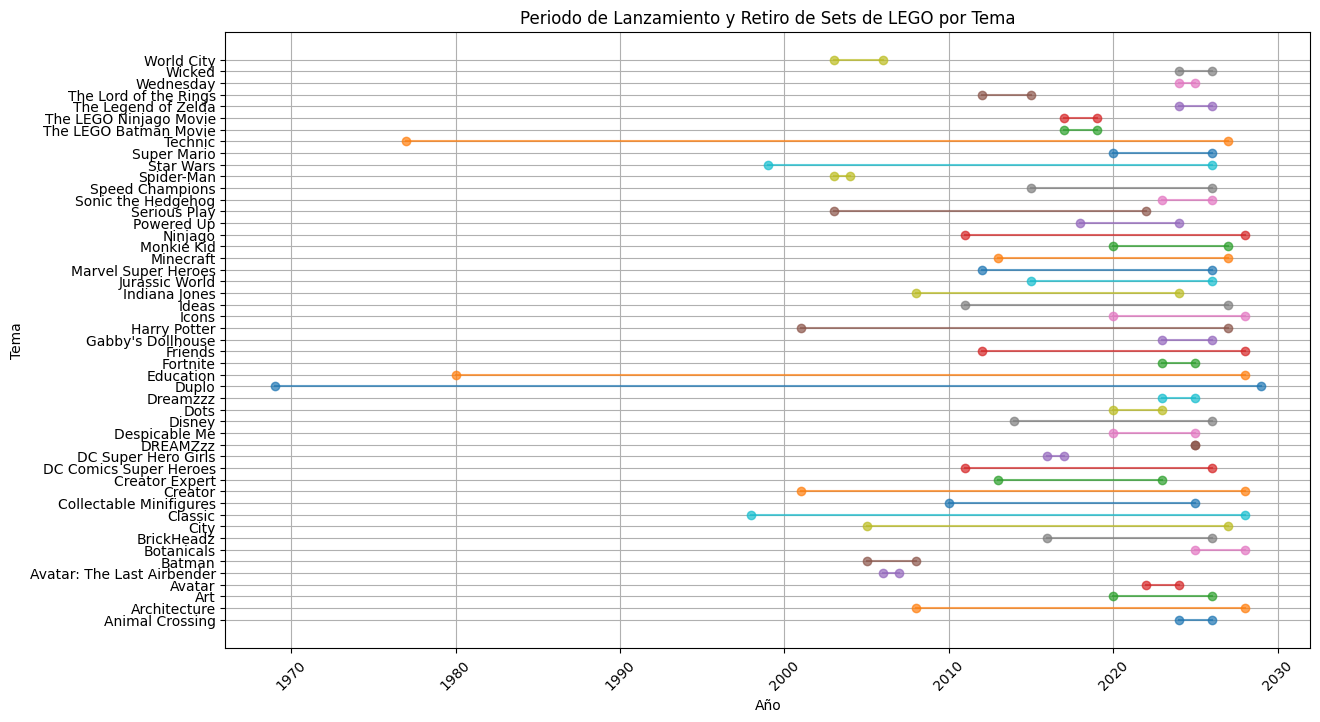

In [ ]:
import matplotlib.pyplot as plt
# Agrupo por tema para obtener los rangos de lanzamiento de sets y retirada
theme_ranges = df_lego.groupby('Theme').agg(
    LaunchStart=('LaunchYear', 'min'),
    LaunchEnd=('ExitYear', 'max')
).reset_index()

# Creo el gráfico
plt.figure(figsize=(14, 8))

# Marco los intervalos de lanzamiento y retirada de cada tema
for index, row in theme_ranges.iterrows():
    plt.plot([row['LaunchStart'], row['LaunchEnd']], [row['Theme'], row['Theme']], marker='o', linestyle='-', alpha=0.7)

# Configuro el gráfico
plt.xlabel('Año')
plt.ylabel('Tema')
plt.title('Periodo de Lanzamiento y Retiro de Sets de LEGO por Tema')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()


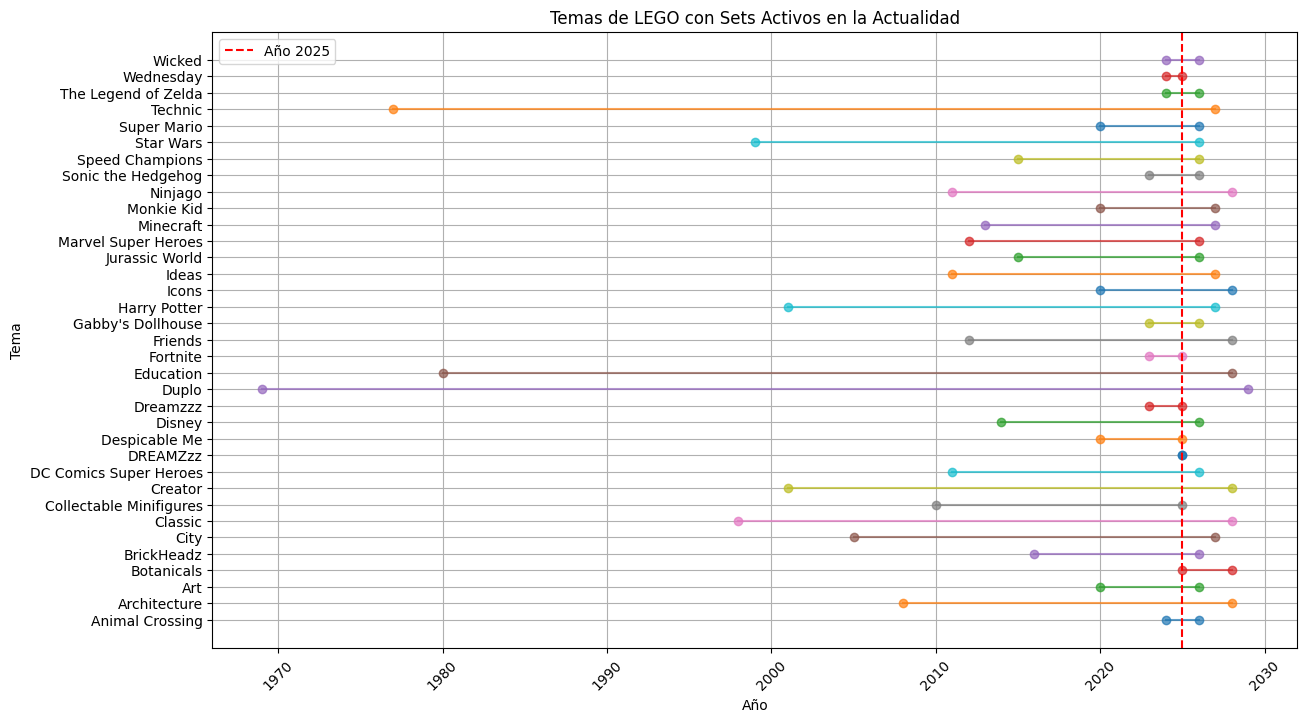

In [537]:
# Agrupo por tema para obtener los rangos de lanzamiento y retirada
theme_ranges = df_lego.groupby('Theme').agg(
    LaunchStart=('LaunchYear', 'min'),
    LaunchEnd=('ExitYear', 'max')
).reset_index()

# Filtro los temas que tienen sets activos en 2025
active_themes = theme_ranges[theme_ranges['LaunchEnd'] >= 2025]

# Filtro el contenido para mostrar solo los temas activos y agrego una línea en 2025 para que sea más fácil de visualizar
plt.figure(figsize=(14, 8))

for index, row in active_themes.iterrows():
    plt.plot([row['LaunchStart'], row['LaunchEnd']], [row['Theme'], row['Theme']], marker='o', linestyle='-', alpha=0.7)

# Agrego una línea vertical para el año 2025
plt.axvline(x=2025, color='r', linestyle='--', label='Año 2025')

# Configuro el gráfico
plt.xlabel('Año')
plt.ylabel('Tema')
plt.title('Temas de LEGO con Sets Activos en la Actualidad')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.show()


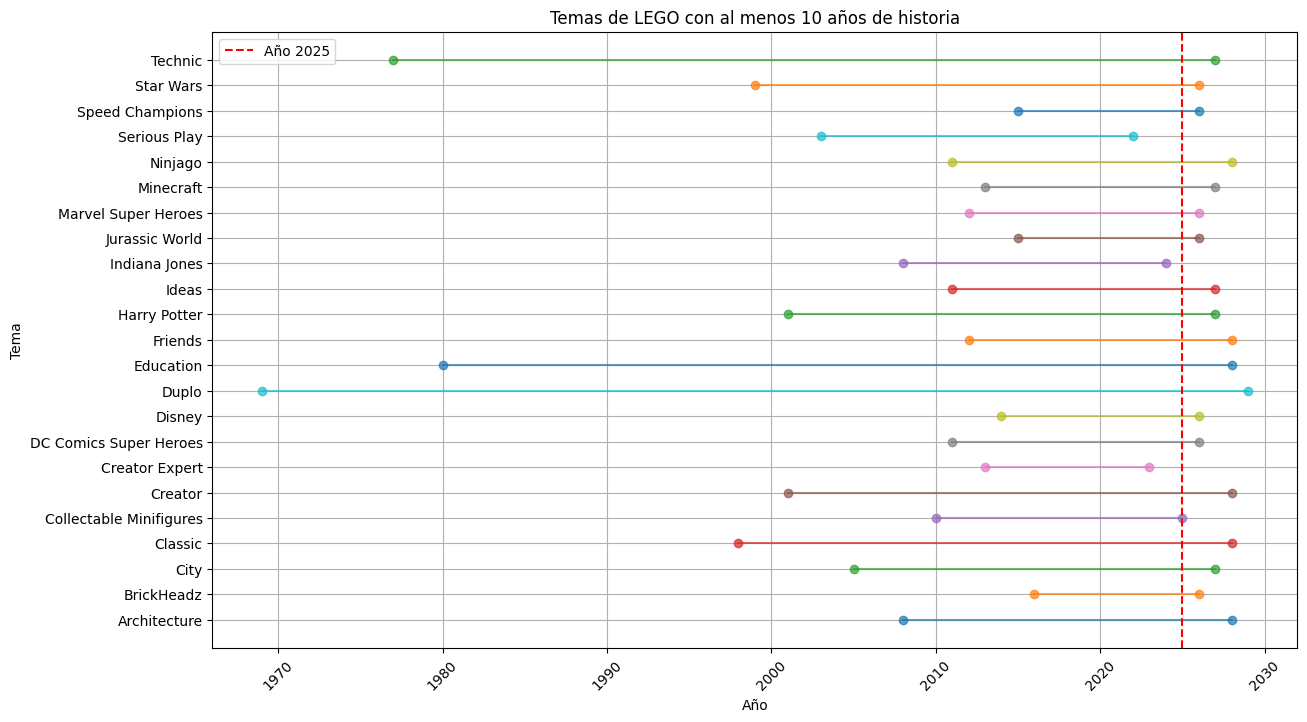

In [538]:
# Hago un filtro de nuevo con los temas que tienen al menos 10 años de historia
long_term_themes = theme_ranges[(theme_ranges['LaunchEnd'] - theme_ranges['LaunchStart']) >= 10]

# Creo el gráfico solo con los temas que tienen al menos 10 años de historia
plt.figure(figsize=(14, 8))

for index, row in long_term_themes.iterrows():
    plt.plot([row['LaunchStart'], row['LaunchEnd']], [row['Theme'], row['Theme']], marker='o', linestyle='-', alpha=0.7)

# Agrego una línea vertical para el año 2025
plt.axvline(x=2025, color='r', linestyle='--', label='Año 2025')

plt.xlabel('Año')
plt.ylabel('Tema')
plt.title('Temas de LEGO con al menos 10 años de historia')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.show()


In [527]:
df_lego

,SetID,Number,YearFrom,Category,Theme,Subtheme,SetName,ImageFilename,USRetailPrice,Pieces,...,YearsSinceExit,PriceChange,ResaleDemand,AppreciationTrend,SizeCategory,Exclusivity,ThemePopularity,InvestmentScore,AnnualPriceIncrease,AnnualPercentageIncrease
0,7530,10,1973,Normal,Duplo,Unknown,Pre-School Set,Unknown,0.0,17.0,...,51,0.0,0.000000,0.0,Small,Regular,0.0,0.0,0.000000,0.0
1,7531,20,1973,Normal,Duplo,Unknown,Building Set,Unknown,0.0,25.0,...,51,0.0,0.000000,0.0,Small,Regular,0.0,0.0,0.000000,0.0
2,1119,28,1979,Normal,Duplo,Unknown,Nursery Furniture,028-1,0.0,7.0,...,45,0.0,0.000000,0.0,Small,Regular,0.0,0.0,0.000000,0.0
3,7532,30,1973,Normal,Duplo,Unknown,Building Set,Unknown,0.0,29.0,...,51,0.0,0.000000,0.0,Small,Regular,0.0,0.0,0.000000,0.0
4,1382,32,1979,Normal,Duplo,Unknown,Living Room Furniture,032-1,0.0,14.0,...,45,0.0,0.000000,0.0,Small,Regular,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9200,22656,WISHINGWELL,2013,Other,Friends,Promotional,Wishing Well,WISHINGWELL-1,0.0,28.0,...,11,0.0,0.000000,0.0,Small,Regular,0.0,0.0,0.000000,0.0
9201,30208,XWING,2019,Other,Star Wars,Promotional,X-wing Trench Run,XWING-2,0.0,52.0,...,5,NaN,0.694707,NaN,Small,Exclusive,0.0,NaN,2.940000,0.0
9202,29327,XWING,2019,Other,Star Wars,Promotional,Mini X-wing Fighter,XWING-1,0.0,60.0,...,5,0.0,0.000000,0.0,Small,Exclusive,0.0,10.0,0.000000,0.0
9203,22978,YODA,2013,Other,Star Wars,Promotional,"Yoda minifig, NY I Heart Torso",YODA-1,0.0,3.0,...,11,NaN,0.000000,NaN,Small,Exclusive,0.0,NaN,256.936364,0.0


In [528]:
df_lego.dtypes

SetID                          int64
Number                        object
YearFrom                       int64
Category                      object
Theme                         object
Subtheme                      object
SetName                       object
ImageFilename                 object
USRetailPrice                float64
Pieces                       float64
Minifigs                     float64
PackagingType                 object
Availability                  object
Width                        float64
Height                       float64
Depth                        float64
Weight                       float64
AgeMin                       float64
AgeMax                       float64
OwnCount                       int64
WantCount                      int64
Rating                         int64
BrickLinkSoldPriceNew        float64
BrickLinkSoldPriceUsed       float64
LaunchYear                     int32
LaunchMonth                    int32
ExitYear                       int64
E

In [529]:
# Filtrar los sets con ExitYear menor a 2025
df_lego_filtered = df_lego[df_lego['ExitYear'] < 2025]

# Recalcular AnnualPercentageIncrease
df_lego_filtered['AnnualPercentageIncrease'] = ((df_lego_filtered['BrickLinkSoldPriceNew'] - df_lego_filtered['USRetailPrice']) / 
                                                (df_lego_filtered['USRetailPrice'] * df_lego_filtered['YearsSinceExit'])) * 100

# Reemplazar valores infinitos o NaN
df_lego_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)
df_lego_filtered['AnnualPercentageIncrease'].fillna(0, inplace=True)

# Contar la cantidad de sets con revalorización (AnnualPercentageIncrease ≠ 0) por Theme
theme_revalued_counts = df_lego_filtered[df_lego_filtered['AnnualPercentageIncrease'] != 0].groupby('Theme').size()

# Contar el total de sets por Theme
theme_total_counts = df_lego_filtered.groupby('Theme').size()

# Calcular el porcentaje de sets revalorizados en cada tema
theme_revaluation_percentage = (theme_revalued_counts / theme_total_counts) * 100

# Unir en un solo dataframe para mejor visualización
theme_analysis_filtered = pd.DataFrame({
    "Total Sets": theme_total_counts,
    "Revalued Sets": theme_revalued_counts,
    "Percentage Revalued": theme_revaluation_percentage
}).fillna(0).sort_values(by="Percentage Revalued", ascending=False)


/var/folders/41/9xs275yn7jxbs_h59j3pq3sw0000gn/T/ipykernel_2720/3957928404.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lego_filtered['AnnualPercentageIncrease'] = ((df_lego_filtered['BrickLinkSoldPriceNew'] - df_lego_filtered['USRetailPrice']) /
/var/folders/41/9xs275yn7jxbs_h59j3pq3sw0000gn/T/ipykernel_2720/3957928404.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lego_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/41/9xs275yn7jxbs_h59j3pq3sw0000gn/T/ipykernel_2720/3957928404.py:10: FutureWarning: A value is trying to b

In [530]:
theme_analysis_filtered

,Total Sets,Revalued Sets,Percentage Revalued
Theme,,,
Gabby's Dollhouse,3,3.0,100.000000
Art,15,15.0,100.000000
Avatar,9,9.0,100.000000
Avatar: The Last Airbender,2,2.0,100.000000
Powered Up,15,15.0,100.000000
Creator Expert,36,35.0,97.222222
Indiana Jones,21,20.0,95.238095
The Lord of the Rings,16,15.0,93.750000
BrickHeadz,156,144.0,92.307692


In [531]:
df_lego.to_csv("df_lego_work_limpio.csv", index=False)


In [532]:
df_lego

,SetID,Number,YearFrom,Category,Theme,Subtheme,SetName,ImageFilename,USRetailPrice,Pieces,...,YearsSinceExit,PriceChange,ResaleDemand,AppreciationTrend,SizeCategory,Exclusivity,ThemePopularity,InvestmentScore,AnnualPriceIncrease,AnnualPercentageIncrease
0,7530,10,1973,Normal,Duplo,Unknown,Pre-School Set,Unknown,0.0,17.0,...,51,0.0,0.000000,0.0,Small,Regular,0.0,0.0,0.000000,0.0
1,7531,20,1973,Normal,Duplo,Unknown,Building Set,Unknown,0.0,25.0,...,51,0.0,0.000000,0.0,Small,Regular,0.0,0.0,0.000000,0.0
2,1119,28,1979,Normal,Duplo,Unknown,Nursery Furniture,028-1,0.0,7.0,...,45,0.0,0.000000,0.0,Small,Regular,0.0,0.0,0.000000,0.0
3,7532,30,1973,Normal,Duplo,Unknown,Building Set,Unknown,0.0,29.0,...,51,0.0,0.000000,0.0,Small,Regular,0.0,0.0,0.000000,0.0
4,1382,32,1979,Normal,Duplo,Unknown,Living Room Furniture,032-1,0.0,14.0,...,45,0.0,0.000000,0.0,Small,Regular,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9200,22656,WISHINGWELL,2013,Other,Friends,Promotional,Wishing Well,WISHINGWELL-1,0.0,28.0,...,11,0.0,0.000000,0.0,Small,Regular,0.0,0.0,0.000000,0.0
9201,30208,XWING,2019,Other,Star Wars,Promotional,X-wing Trench Run,XWING-2,0.0,52.0,...,5,NaN,0.694707,NaN,Small,Exclusive,0.0,NaN,2.940000,0.0
9202,29327,XWING,2019,Other,Star Wars,Promotional,Mini X-wing Fighter,XWING-1,0.0,60.0,...,5,0.0,0.000000,0.0,Small,Exclusive,0.0,10.0,0.000000,0.0
9203,22978,YODA,2013,Other,Star Wars,Promotional,"Yoda minifig, NY I Heart Torso",YODA-1,0.0,3.0,...,11,NaN,0.000000,NaN,Small,Exclusive,0.0,NaN,256.936364,0.0


In [533]:
import matplotlib.pyplot as plt

# Agrupar por Theme y obtener el rango de años (mínimo y máximo) de lanzamiento de sets
theme_years = df_lego.groupby("Theme")["YearFrom"].agg(["min", "max"]).reset_index()

# Ordenar los datos por el año mínimo de lanzamiento
theme_years = theme_years.sort_values(by="min")